# Steps to Generate Standardized Precipitation Index Using CHIRPS Data

To generate the **Standardized Precipitation Index** ([SPI](https://library.wmo.int/viewer/39629/download?file=wmo_1090_en.pdf&type=pdf&navigator=1)) - a proxy for meteorological drought, we will use monthly gridded **Satellite precipitation estimates** from Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS) is a 35+ year quasi-global rainfall data set. (paper: [https://doi.org/10.1038/sdata.2015.66](https://doi.org/10.1038/sdata.2015.66)). 

The data it self are available for download from the [https://data.chc.ucsb.edu/products/CHIRPS-2.0/](https://data.chc.ucsb.edu/products/CHIRPS-2.0/)

Let's assume we are working in the `python` or `conda` environment, with packages installed: `nco`, `cdo`, `gdal`, `numpy`, `xarray`, `climate-indices` and probably other necessary packages.

## 0. Working Directory

For this exercise, I am working on these folder `/Temp/drought/met/` (applied to Mac/Linux machine) or `Z:/Temp/drought/met/` (applied to Windows machine) directory. I have some folder inside this directory:

1. `00_downloads` # Place to put downloaded gridded precipitation data.
2. `01_clipped` # As the downloaded files is come with global coverage, we'll need to clip it using bounding box, this folder is place to save the clip process.
3. `02_aoi` # Place to put nc files from fill the null value near the coastline by interpolating from nearest grid process, matched the grid with the subset, and remove the value over the sea.
4. `03_metadata_revision` # Revised nc file from metadata editing before the SPI calculation.
5. `04_spi_intermediate` # Output from SPI calculation goes here.
6. `05_spi` # Final SPI output that is CF-Compliant.
7. `images` # In this folder I put some screenshot file as illustration, used in this notebook.

Feel free to use your own preferences for this setting/folder arrangements.

This step-by-step guide was tested using Windows 11 with WSL2 - Ubuntu 22 enabled running on Thinkpad T480 2019, i7-8650U 1.9GHz, 64 GB 2400 MHz DDR4.

## 1. Download the data

Navigate to `00_downloads` folder

In [1]:
%cd ./met/00_downloads

/Volumes/Datenspeicherung/Temp/drought/met/00_downloads


Then execute below code to download the data. 

In [2]:
!wget -c https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_monthly/netcdf/chirps-v2.0.monthly.nc

--2023-12-01 15:51:50--  https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_monthly/netcdf/chirps-v2.0.monthly.nc
Resolving data.chc.ucsb.edu (data.chc.ucsb.edu)... 128.111.100.31
Connecting to data.chc.ucsb.edu (data.chc.ucsb.edu)|128.111.100.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7224218840 (6.7G) [application/x-netcdf]
Saving to: ‘chirps-v2.0.monthly.nc’

chirps-v2.0.monthly 100%[===================>]   6.73G  3.68MB/s    in 14m 22s 

2023-12-01 16:06:13 (7.99 MB/s) - ‘chirps-v2.0.monthly.nc’ saved [7224218840/7224218840]



## 2. Pre process

The first process will be clip the area of interest using bounding box. Example: Indonesia bounding box with format `lon1`,`lon2`,`lat1`,`lat2` is `90,145,-13,11`

In this command:

* `-selyear,1981/2022` selects the years from 1981 to 2022.
* `sellonlatbox,90,145,-13,11` selects the spatial region with longitudes from 90 to 145 degrees and latitudes from -13 to 11 degrees.
* The operations are applied in sequence: first, the time range is selected, and then the spatial clipping is applied.

In [4]:
!cdo -z zip_5 sellonlatbox,90,145,-13,11 -selyear,1981/2022 chirps-v2.0.monthly.nc ../01_clipped/idn_cli_chirps_precip_monthly.nc

cdo(1) selyear: Process started
cdo(1) selyear: Processed 7257600000 values from 1 variable over 514 timesteps
cdo    sellonlatbox: Processed 7257600000 values from 1 variable over 504 timesteps [125.80s 1621MB]


Navigate to folder 01_clipped

In [2]:
%cd ../01_clipped

/Volumes/Datenspeicherung/Temp/drought/met/01_clipped


Next process will be fill the null value near the coastline by interpolating from nearest grid process, matched the grid with the subset, and remove the value over the sea.

Below script combine the operations into a one-liner script for each file, and use in-memory processing for intermediate outputs. 

This script performs the following operations for each `.nc4` file:

* `-remapbil,../subset/idn_subset_chirps.nc $fl` - Remaps the input file `$fl` to match the grid of your subset file.
* `-fillmiss -` - Fills missing values in the remapped data. The `-` symbol is used to take the output of `remapbil` as input for `fillmiss`.
* `ifthen ../subset/idn_subset_chirps.nc -` - Applies the ifthen operation using the subset file as the condition to keep data only on land. The `-` symbol takes the output of `fillmiss` as its input.
* The final output for each file is saved in the `../02_aoi/` directory.

This approach avoids writing intermediate files to disk by using in-memory streams.

In [3]:
!cdo -z zip_5 ifthen ../../subset/idn_subset_chirps.nc -fillmiss -remapbil,../../subset/idn_subset_chirps.nc idn_cli_chirps_precip_monthly.nc ../02_aoi/idn_cli_chirps_precip_1981_2022.nc


cdo(1) fillmiss: Process started
cdo(2) remapbil: Process started
cdo    ifthen: Filling up stream1 >../../subset/idn_subset_chirps.nc< by copying the first timestep.
cdo(2) remapbil: Bilinear weights from lonlat (1100x480) to lonlat (923x341) grid, with source mask (111929)
cdo(2) remapbil:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    ifthen (Warning): Variable land has a missing value of 0, this can lead to incorrect results with this operator!
cdo(2) remapbil: Processed 266112000 values from 1 variable over 504 timesteps
cdo(1) fillmiss: Processed 158630472 values from 1 variable over 504 timesteps
cdo    ifthen: Processed 158945215 values from 2 variables over 505 timesteps [72.69s 173MB]


Navigate to folder `02_aoi`

In [4]:
%cd ../02_aoi

/Volumes/Datenspeicherung/Temp/drought/met/02_aoi


Check the result from previous process.

In [11]:
!ncdump -h idn_cli_chirps_precip_1981_2022.nc

netcdf idn_cli_chirps_precip_1981_2022 {
dimensions:
	time = UNLIMITED ; // (504 currently)
	lon = 923 ;
	lat = 341 ;
variables:
	float time(time) ;
		time:standard_name = "time" ;
		time:units = "days since 1980-1-1 0:0:0" ;
		time:calendar = "gregorian" ;
		time:axis = "T" ;
	double lon(lon) ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude coordinate" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	double lat(lat) ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude coordinate" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	float precip(time, lat, lon) ;
		precip:standard_name = "convective precipitation rate" ;
		precip:long_name = "Climate Hazards group InfraRed Precipitation with Stations" ;
		precip:units = "mm/month" ;
		precip:_FillValue = -9999.f ;
		precip:missing_value = -9999.f ;
		precip:time_step = "month" ;
		precip:geostatial_lat_min = -50.f ;
		precip:geostatial_lat_max = 50.f ;
		precip:geostatial_lon_min = -180.f ;
		precip:g

## 3. Modify the metadata

We need to modify/add some variables in order to prepared the data for the SPI calculation. Edit precipitation unit from `mm/month` to `mm`


In [12]:
!cdo -z zip_5 -setattribute,precip@units="mm" idn_cli_chirps_precip_1981_2022.nc ../03_metadata_revision/idn_cli_chirps_precip_1981_2022.nc

cdo    setattribute: Processed 158630472 values from 1 variable over 504 timesteps [20.99s 145MB]


Navigate to folder `03_metadata_revision`

In [5]:
%cd ../03_metadata_revision

/Volumes/Datenspeicherung/Temp/drought/met/03_metadata_revision


Check the result from previous process.

In [14]:
!ncdump -h idn_cli_chirps_precip_1981_2022.nc

netcdf idn_cli_chirps_precip_1981_2022 {
dimensions:
	time = UNLIMITED ; // (504 currently)
	lon = 923 ;
	lat = 341 ;
variables:
	float time(time) ;
		time:standard_name = "time" ;
		time:units = "days since 1980-1-1 0:0:0" ;
		time:calendar = "gregorian" ;
		time:axis = "T" ;
	double lon(lon) ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude coordinate" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	double lat(lat) ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude coordinate" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	float precip(time, lat, lon) ;
		precip:standard_name = "convective precipitation rate" ;
		precip:long_name = "Climate Hazards group InfraRed Precipitation with Stations" ;
		precip:units = "mm" ;
		precip:_FillValue = -9999.f ;
		precip:missing_value = -9999.f ;
		precip:time_step = "month" ;
		precip:geostatial_lat_min = -50.f ;
		precip:geostatial_lat_max = 50.f ;
		precip:geostatial_lon_min = -180.f ;
		precip:geostat

## 4. Standardized Precipitation Index calculation

Let's read some paragraph below related to the python package that we will use to calculate the SPI.

The [climate-indices](https://pypi.org/project/climate-indices/) python package enables the user to calculate SPI using any gridded netCDF dataset. However, there are certain requirements for input files that vary based on input type.

* Precipitation unit must be written as `millimeters`, `milimeter`, `mm`, `inches`, `inch` or `in`.

* Data dimension and order must be written as `lat`, `lon`, `time` (Windows machine required this order) or `time`, `lat`, `lon` (Works tested on Mac/Linux and Linux running on WSL). 

* If our study area are big, it's better to prepare all the data following this dimension order: `lat`, `lon`, `time` as all the data will force following this order during SPI calculation by NCO module. Let say you only prepare the data as is (leaving the order to `time`,`lat`, `lon`), it also acceptable but it will required lot of memory to use re-ordering the dimension, and usually NCO couldn't handle all the process and failed.

Please make sure below points:

- [x] You have installed `climate-indices` package to start working on SPI calculation. 
- [x] Variable name on precipitation `--var_name_precip`, usually terraclimate data use `ppt` as name while other precipitation data like CHIRPS using `precip` and IMERG using `precipitation` as a variable name. To make sure, check using command `ncdump -h file.nc` then adjust it in SPI script if needed.


Let's re-order the variables into `lat`,`lon`,`time` using `ncpdq` command

In [15]:
!ncpdq -a lat,lon,time idn_cli_chirps_precip_1981_2022.nc input0.nc

Check the header for the result `input0.nc`

In [16]:
!ncdump -h input0.nc

netcdf input0 {
dimensions:
	time = 504 ;
	lon = 923 ;
	lat = UNLIMITED ; // (341 currently)
variables:
	float time(time) ;
		time:standard_name = "time" ;
		time:units = "days since 1980-1-1 0:0:0" ;
		time:calendar = "gregorian" ;
		time:axis = "T" ;
	double lon(lon) ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude coordinate" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	double lat(lat) ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude coordinate" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	float precip(lat, lon, time) ;
		precip:standard_name = "convective precipitation rate" ;
		precip:long_name = "Climate Hazards group InfraRed Precipitation with Stations" ;
		precip:units = "mm" ;
		precip:_FillValue = -9999.f ;
		precip:missing_value = -9999.f ;
		precip:time_step = "month" ;
		precip:geostatial_lat_min = -50.f ;
		precip:geostatial_lat_max = 50.f ;
		precip:geostatial_lon_min = -180.f ;
		precip:geostatial_lon_max = 180.f ;

//

After re-ordering the variables, sometimes user experience `lat` or `lon` dimension becomes `UNLIMITED` which is wrong. The `time` dimension should be the `UNLIMITED` dimension.

Fortunately you can do this to fix the `lat` or `lon` dimension who becomes `UNLIMITED` using `ncks` command below:

In [17]:
!ncks --fix_rec_dmn lat input0.nc -o input1.nc

And to make `UNLIMITED` the `time` dimension again using `ncks` command below:

In [18]:
!ncks --mk_rec_dmn time input1.nc -o input_spi.nc

Check the header for the result `input_spi.nc`

In [19]:
!ncdump -h input_spi.nc

netcdf input_spi {
dimensions:
	lat = 341 ;
	lon = 923 ;
	time = UNLIMITED ; // (504 currently)
variables:
	double lat(lat) ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude coordinate" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	double lon(lon) ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude coordinate" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	float precip(lat, lon, time) ;
		precip:standard_name = "convective precipitation rate" ;
		precip:long_name = "Climate Hazards group InfraRed Precipitation with Stations" ;
		precip:units = "mm" ;
		precip:_FillValue = -9999.f ;
		precip:missing_value = -9999.f ;
		precip:time_step = "month" ;
		precip:geostatial_lat_min = -50.f ;
		precip:geostatial_lat_max = 50.f ;
		precip:geostatial_lon_min = -180.f ;
		precip:geostatial_lon_max = 180.f ;
	float time(time) ;
		time:standard_name = "time" ;
		time:units = "days since 1980-1-1 0:0:0" ;
		time:calendar = "gregorian" ;
		time:axis = "T" ;


**Let's start the calculation!**

In [22]:
!spi --periodicity monthly --scales 1 2 3 6 9 12 18 24 36 48 60 72 --calibration_start_year 1991 --calibration_end_year 2020 --netcdf_precip input_spi.nc --var_name_precip precip --output_file_base ../04_spi_intermediate/idn_cli --multiprocessing all

2023-12-01  18:19:12 INFO Start time:    2023-12-01 18:19:12.794650
2023-12-01  18:19:13 INFO Computing monthly SPI
2023-12-01  18:19:32 INFO Computing 1-month SPI (Gamma)
2023-12-01  18:20:11 INFO Computing 1-month SPI (Pearson)
/opt/anaconda3/envs/wbg/lib/python3.10/site-packages/climate_indices/compute.py:455: RuntimeWarning: divide by zero encountered in divide
  alpha = 4.0 / (skew * skew)
/opt/anaconda3/envs/wbg/lib/python3.10/site-packages/climate_indices/compute.py:459: RuntimeWarning: invalid value encountered in multiply
  return loc - ((alpha * scale * skew) / 2.0)
/opt/anaconda3/envs/wbg/lib/python3.10/site-packages/climate_indices/compute.py:455: RuntimeWarning: divide by zero encountered in divide
  alpha = 4.0 / (skew * skew)
/opt/anaconda3/envs/wbg/lib/python3.10/site-packages/climate_indices/compute.py:459: RuntimeWarning: invalid value encountered in multiply
  return loc - ((alpha * scale * skew) / 2.0)
/opt/anaconda3/envs/wbg/lib/python3.10/site-packages/climate_ind

We will use the gamma version, lets remove the pearson file. Don't forget to navigate to `04_spi_intermediate`

In [6]:
%cd ../04_spi_intermediate

!bash -c 'rm idn_cli_spi_pearson_*.nc'

/Volumes/Datenspeicherung/Temp/drought/met/04_spi_intermediate
rm: idn_cli_spi_pearson_*.nc: No such file or directory


Next, we need to re-rder the dimension back to `time`,`lat`,`lon` in order to follow the [CF Convention](https://cfconventions.org/conventions.html) and also for further processing using CDO, and CDO required the variable should be in `time`,`lat`,`lon`, while the output from SPI in `lat`,`lon`,`time`.

Let's re-order the variables into `time`,`lat`,`lon` using `ncpdq` command from NCO and save the result to folder `05_spi`

In [24]:
!bash -c 'for fl in *.nc; do ncpdq -a time,lat,lon $fl ../05_spi/$fl; done'

Navigate to folder `05_spi`

In [7]:
%cd ../05_spi

/Volumes/Datenspeicherung/Temp/drought/met/05_spi


Check the header for the result one of the output file `idn_cli_spi_gamma_12_month`

In [29]:
!ncdump -h idn_cli_spi_gamma_12_month.nc

netcdf idn_cli_spi_gamma_12_month {
dimensions:
	lat = 341 ;
	lon = 923 ;
	time = 504 ;
variables:
	double lat(lat) ;
		lat:_FillValue = NaN ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude coordinate" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	double lon(lon) ;
		lon:_FillValue = NaN ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude coordinate" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	float time(time) ;
		time:_FillValue = NaNf ;
		time:standard_name = "time" ;
		time:axis = "T" ;
		time:units = "days since 1980-01-01" ;
		time:calendar = "gregorian" ;
	double spi_gamma_12_month(time, lat, lon) ;
		spi_gamma_12_month:_FillValue = NaN ;
		spi_gamma_12_month:long_name = "Standardized Precipitation Index (Gamma), 12-month" ;
		spi_gamma_12_month:valid_min = -3.09 ;
		spi_gamma_12_month:valid_max = 3.09 ;

// global attributes:
		:description = "SPI for 12-month scale computed from monthly precipitation input by the climate_indices p

Seems everything is correct from above result, congrats now we have the SPI data.

## 5. Visualising the SPI

To see the result, let's visualise it for the year 2022, using SPI 12-month data.

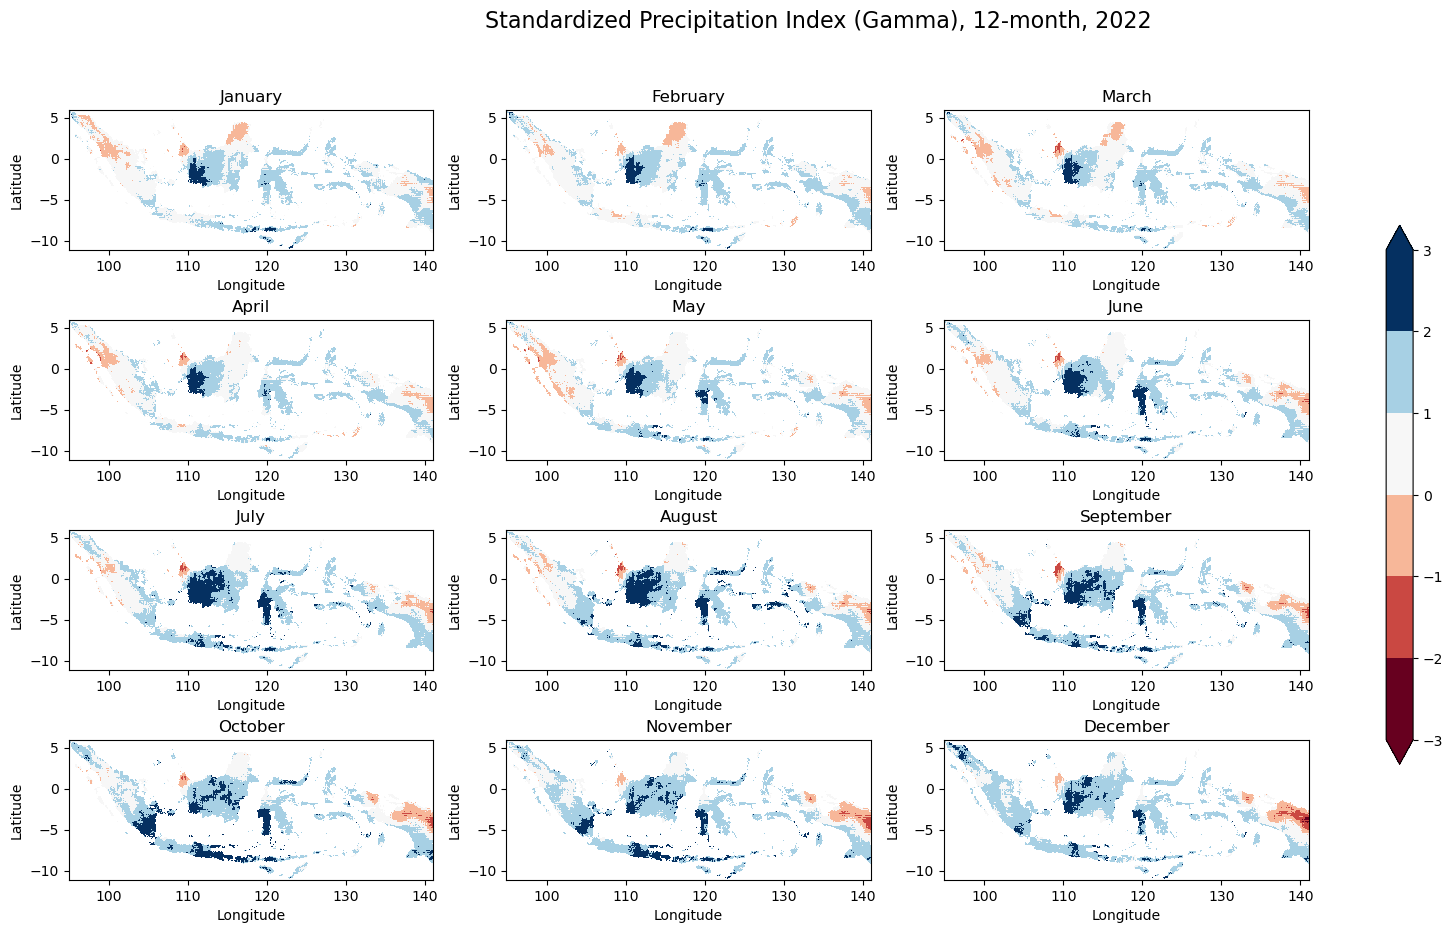

In [30]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd

# Load the dataset
ds = xr.open_dataset("idn_cli_spi_gamma_12_month.nc")

# Select data from Jan - Dec 2022
start_date = "2022-01-01"
end_date = "2022-12-31"
data_2022 = ds["spi_gamma_12_month"].sel(time=slice(start_date, end_date))

# Plotting
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 10))
fig.suptitle('Standardized Precipitation Index (Gamma), 12-month, 2022', fontsize=16, y=0.98)

# Custom discrete color map
cmap = plt.get_cmap('RdBu', 7)  # 7 discrete colors
bounds = [-3, -2, -1, 0, 1, 2, 3]
norm = colors.BoundaryNorm(bounds, cmap.N)

for i, ax in enumerate(axes.flat):
    # Plot if the data for the month exists
    if i < len(data_2022.time):
        data = data_2022.isel(time=i)
        pcm = ax.pcolormesh(data.lon, data.lat, data, cmap=cmap, norm=norm)
        
        # Set title with the corresponding month
        time_val = pd.to_datetime(str(data.time.values))
        ax.set_title(time_val.strftime('%B'))

        # Set labels
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

# Adjust vertical spacing
plt.subplots_adjust(hspace=0.5)  # Adjust this value as needed for vertical spacing
fig.colorbar(pcm, ax=axes.ravel().tolist(), shrink=0.7, ticks=np.arange(-3, 4), extend='both')

# Save the map as a PNG
plt.savefig('../images/idn_cli_chirps_spi12_2022.png', dpi=300)
plt.show()


End of notebook.